### Lista de exercícios - exercício 2

**Aluno:** André F. Oliveira

Apesar do exercício pedir o uso do algoritmo [colorednoise](https://github.com/felixpatzelt/colorednoise), este código utiliza a tradução para python feita a partir do arquivo **powernoise.m** enviado pelo Prof. Dr. Reinaldo Rosa. O algoritmo **powernoise** gera amostras de ruído de leis de potência, onde a potência do espectro de sinais é escalado por $f^{(-beta)}$. Um expoente beta igual a 2 corresponde a ruído browniano. Expoentes menores geram correlações de longo alcance, isto é, ruído rosa para um expoente 1 e um ruído branco para expoente 0. Vale notar que não há necessidade da incorporação de uma função para normalizar os pontos gerados pelo código, já que isto pode ser feito diretamente com o algoritmo **powernoise** ao utilizar a opção *'normalize'* como entrada.

Como comentado no exercício anterior, este código foi construído com base no algoritmo do primeiro exercício, realizando as mesmas operações mas com um algoritmo que gera ruídos coloridos. Resumidamente, o código realiza as seguintes operações:<br>
**1 -** Gera vinte sinais referentes aos ruídos branco, rosa e vermelho já normalizados;<br>
**2 -** Calcula os momentos estatísticos destes sinais e os armazena em um dataframe;<br>
**3 -** Usa o algoritmo do k-means para agrupar os momentos estatísticos;<br>
**4 -** Exibe os gráficos com os resultados do k-means no espaço de parâmetros formados pelos momentos;<br>
**5 -** Identifica e mostra os sinais alocados em cada cluster;<br>
**6 -** Plota algum sinal de acordo com os valores de beta fornecidos pelo usuário;<br>
**7 -** Guarda os resultados em arquivos csv se o usuário assim escolher.<br>

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import *
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import powernoise as pn
import os
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.titlesize'] = 15
plt.rcParams['axes.labelsize'] = 14
plt.style.use('seaborn')


def fold_creator(path):
    """
    Se o diretório não existe, cria o diretório com o valor de path
    """
    if not os.path.exists(path):
        os.makedirs(path)


def nome_unico(nome_arquivo):
    """
    Se o arquivo existe, adiciona um número ao seu nome.
    Ex: se momentos_1.csv existe, cria arquivo momentos_2.csv
    """
    f = 0
    while os.path.exists(nome_arquivo):
        f += 1
        ext = '.' + nome_arquivo.split('.')[1]
        num = int(nome_arquivo.split('.')[0][-1]) + f
        nome_arquivo = nome_arquivo.split('.')[0][:-1] + str(num) + ext
    return nome_arquivo


class GeradorRuido:
    """
    Gerador de Série Temporal Estocástica - V.1.2 por R.R.Rosa.
    Trata-se de um gerador randômico não-gaussiano sem classe de universalidade via PDF.
    """

    def __init__(self, n, beta, sinais, histograma=False):
        """
        Inicializador dos parâmetros de entrada
        =======================================
        Inputs
        N: número de amostras
        beta: valor do expoente para cálculo do ruído - 0: ruído branco, 1: ruído rosa, 2: ruído vermelho
        sinais: quantidade de sinais a serem gerados para cada ruído
        histograma: mostra na tela os histogramas de cada família de sinais.Padrão é False
        """
        self.amostras = n
        self.n_sinais = sinais
        self.hist = histograma

        # Instâncias que serão definidas dentro das funções
        self.df = None

        # Listas para armazenar os arquivos a serem salvos em csv
        self.sinais = []
        self.momentos = []
        self.k_means = []

        # Se beta não for uma lista, transforma em lista
        if not isinstance(beta, list):
            beta = list(beta)

        # Executa o código para cada valor de beta
        for num in beta:
            self.sinal(num)

        # Depois de executar todo o código, calcula o k-means
        self.kmeans(beta)

        # Depois de executar o k-means, pergunta se o usuário deseja plotar os sinais
        self.plot_sinais(beta)

        # Depois de plotar os sinais, pergunta ao usuário se ele deseja salvar os arquivos csv
        salva = False
        while True:
            try:
                s = int(input('\n\nDeseja salvar os valores dos sinas, momentos estatísticos e k-means ' \
                              'em arquivos csv? (0- Não, 1- Sim): '))
            except ValueError:
                print('\n\nDigite 0 para não salvar e 1 para salvar os arquivos em formato csv')
                continue
            else:
                if s == 1:
                    salva = True
                    break
                elif s == 0:
                    break
                else:
                    print('\n\nDigite 0 para não salvar e 1 para salvar os arquivos em formato csv')
                    continue

        if salva:
            self.salva_arquivos()

    def sinal(self, beta):
        """
        Gera uma quantidade de sinais definida pelo usuário
        """

        tmp = []
        for j in range(self.n_sinais):
            tmp.append(pn.powernoise(beta, self.amostras, 'normalize'))

        self.df = pd.DataFrame(np.transpose(tmp), columns=self.colnames(beta)).astype('float64')
        self.sinais.append(self.df)

        # Chama a próxima função
        self.momentos_estatisticos(beta)
        

    def momentos_estatisticos(self, beta):
        """
        Calcula os momentos estatísticos dos ruídos gerados pela função sinal
        """
        # Cria uma cópia do dataframe para ser utilizado somente dentro da função
        tmp = self.df.copy()

        # Altera o nome das colunas para uma melhor manipulação
        tmp.columns = [x for x in range(self.n_sinais)]

        # Função geradora de momentos
        f = lambda i, r: sum((tmp[i] - sum(tmp[i]) / len(tmp[i])) ** r)

        # Variancia
        var = []
        coeff_var = (1 / self.amostras)

        for i in range(self.n_sinais):
            var.append(coeff_var * f(i, 2))

        # Assimetria
        skew = []
        coeff_skew = (sqrt(self.amostras * (self.amostras - 1)) / (self.amostras - 2))

        for j in range(self.n_sinais):
            skew.append(coeff_skew * (coeff_var * f(j, 3) / var[j] ** 1.5))

        # Curtose
        coeff_kurt1 = ((self.amostras - 1) * (self.amostras + 1)) / ((self.amostras - 2) * (self.amostras - 3))
        coeff_kurt2 = 3 * ((self.amostras - 1) ** 2) / ((self.amostras - 2) * (self.amostras - 3))
        kurt = []

        for k in range(self.n_sinais):
            kurt.append(coeff_kurt1 * (coeff_var * f(k, 4) / var[k] ** 2) - coeff_kurt2)

        df_stats = pd.DataFrame(np.transpose((self.colnames(beta), var, skew, kurt)),
                                     columns=['index', 'variance', 'skewness',
                                              'kurtosis']).set_index('index').astype('float64')

        # Guardando cada dataframe em uma lista
        self.momentos.append(df_stats)

        # Chamando a próxima função
        if self.hist:
            self.histograma(beta)

    def histograma(self, beta):
        """
        Grafica os histogramas dos sinais gerados
        """
        fig = plt.figure(figsize=(14, 14))
        number_of_subplots = self.n_sinais
        # Gera um grid para o plot dos histogramas para qualquer quantidade de sinais
        for i, v in enumerate(range(number_of_subplots)):
            v = v + 1
            axes_hist = subplot(number_of_subplots, 1, v)

        # Para garantir que os bins tenham os mesmos tamanhos
        f = int(self.amostras / 64)
        b = int(self.amostras / (3 * f))

        hist_plot = self.df_norm.hist(bins=b, ec="k", alpha=0.6, color='royalblue', ax=axes_hist)

        fig.text(0.5, 1.0, 'Beta = ' + str(beta), ha='center', fontsize=15)
        fig.text(0.5, 0.0, 'Valores de Amplitude Normalizados', ha='center', fontsize=14)
        fig.text(0.0, 0.5, 'Contagem', va='center', rotation='vertical', fontsize=14)
        fig.tight_layout(pad=3.0, h_pad=1.0)

        plt.show()

    def kmeans(self, beta):
        """
        Calcula o k-means para o dataset contendo os valores dos momentos estatísticos
        """

        # Carrega o dataset com os momentos estatísticos
        df_kmeans = pd.concat(self.momentos.copy(), join='inner')

        # Determinando o número ótimo de clusters
        model = KMeans()
        visualizer = KElbowVisualizer(model, k=(1, 10))
        visualizer.fit(df_kmeans)
        plt.close()

        # Calculando o k-means
        n_clusters = visualizer.elbow_value_  # Número ótimo de clusters
        kmeans = KMeans(n_clusters=n_clusters)
        kmeans.fit(df_kmeans)
        df_kmeans['K_classes'] = kmeans.labels_
        self.k_means.append(df_kmeans)

        # Plotando as relações a pares de cada medida estatística (seaborn)
        plt.style.use("seaborn")
        colors = sns.color_palette('tab10', n_clusters)
        g = sns.pairplot(df_kmeans, 'K_classes', palette=colors)
        g.fig.suptitle('\n\nEspaço de parâmetros: V x S x K', y=1.09)

        plt.show()

        # Plotando os pontos em 3 dimensões
        fig = plt.figure(figsize=(20, 15))
        ax = fig.add_subplot(111, projection='3d')

        labels = df_kmeans.groupby('K_classes')
        for key, item in labels:
            ax.scatter(item['variance'], item['skewness'], item['kurtosis'], label=key,
                       alpha=1, s=200, edgecolors='b', c=[colors[key]])

        # Plotandos os centróides em 3 dimensões
        x = []
        y = []
        z = []
        for row in kmeans.cluster_centers_:
            x.append(row[0])
            y.append(row[1])
            z.append(row[2])

        ax.scatter(x, y, z, alpha=0.4, s=500, label='Centróides')

        # Ajustando os eixos
        ax.set_xlabel('\n\n' + df_kmeans.columns[0], fontsize=20)
        ax.set_ylabel('\n\n' + df_kmeans.columns[1], fontsize=20)
        ax.set_zlabel('\n\n' + df_kmeans.columns[2], fontsize=20)
        ax.xaxis.set_tick_params(labelsize=18)
        ax.yaxis.set_tick_params(labelsize=18)
        ax.zaxis.set_tick_params(labelsize=18)

        plt.tight_layout()
        plt.legend(loc='best', fontsize=20)
        plt.show()

    def plot_sinais(self, beta):
        """
        Plota um sinal e seu histograma correspondente à escolha do usuário
        """

        cluster = pd.concat(self.k_means.copy(), join='inner')
        for classe in pd.unique(cluster['K_classes']):
            print(f'\n\n****************** Sinais na classe {classe} ******************')
            print(cluster.loc[cluster['K_classes'] == classe])

        sinais = pd.concat(self.sinais, axis=1)

        while True:
            try:
                p = int(input('\n\nDeseja plotar algum dos sinais? (0- Não, 1- Sim): '))
            except ValueError:
                print('\n\nDigite 0 para não plotar ou 1 para plotar')
                continue
            else:
                if int(p) == 1:
                    try:
                        a = int(input('Valor de beta: '))
                        b = int(input('Número da iteração: '))
                    except ValueError:
                        print('\n\nDigite o valor de beta e da iteração cujo sinal deseja graficar')
                    else:
                        if not 'beta:' + str(a) + ' ' + 'iter:' + str(b) in sinais.columns:
                            print('\n\nValores inválidos!')
                            continue
                        else:

                            for nome in cluster.index.values:
                                valor_beta = nome.split(' ')[0]
                                valor_iter = nome.split(' ')[1]
                                if 'beta:' + str(a) == valor_beta and 'iter:' + str(b) == valor_iter:
                                    fig, ax = plt.subplots(1, 2, sharey=True, squeeze=False, figsize=(14, 5),
                                                           gridspec_kw={'width_ratios': [4, 1]})
                                    ax[0, 0].plot(sinais[valor_beta + ' ' + valor_iter])
                                    ax[0, 1].hist(sinais[valor_beta + ' ' + valor_iter], orientation='horizontal')

                                    ax[0, 0].set_xlabel('Tempo (t)')
                                    ax[0, 0].set_ylabel('Amplitude A(t)')

                                    ax[0, 1].set_xlabel('Contagem')
                                    plt.tight_layout()
                                    plt.show()

                elif int(p) == 0:
                    break

                else:
                    print('\n\nDigite 0 para não plotar ou 1 para plotar')

    def colnames(self, beta):
        """
        Retorna uma lista com as strings dos valores de N e sinal atuais
        """

        col = []
        for i in range(self.n_sinais):
            col.append('beta:' + str(beta) + ' ' + 'iter:' + str(i))

        return col

    def salva_arquivos(self):
        """
        Salva os arquivos em seus respectivos diretórios
        """
        # Cria o diretório para salvar os sinais
        path = 'sinais/'
        fold_creator(path)
        tmp = pd.concat(self.sinais.copy(), axis=1)
        nome_arquivo = path + 'sinais_0.csv'
        nome_arquivo = nome_unico(nome_arquivo)

        tmp.to_csv(nome_arquivo, index=True)

        # Cria o diretório para salvar os momentos estatísticos
        path = 'momentos/'
        fold_creator(path)
        tmp = pd.concat(self.momentos.copy(), join='inner')
        nome_arquivo = path + 'momentos_0.csv'
        nome_arquivo = nome_unico(nome_arquivo)

        tmp.to_csv(nome_arquivo, index=True)

        # Cria o diretório para salvar os resultados so kmeans
        path = 'kmeans/'
        fold_creator(path)
        tmp = pd.concat(self.k_means.copy(), join='inner')
        nome_arquivo = path + 'k_means_0.csv'
        nome_arquivo = nome_unico(nome_arquivo)

        tmp.to_csv(nome_arquivo, index=True)

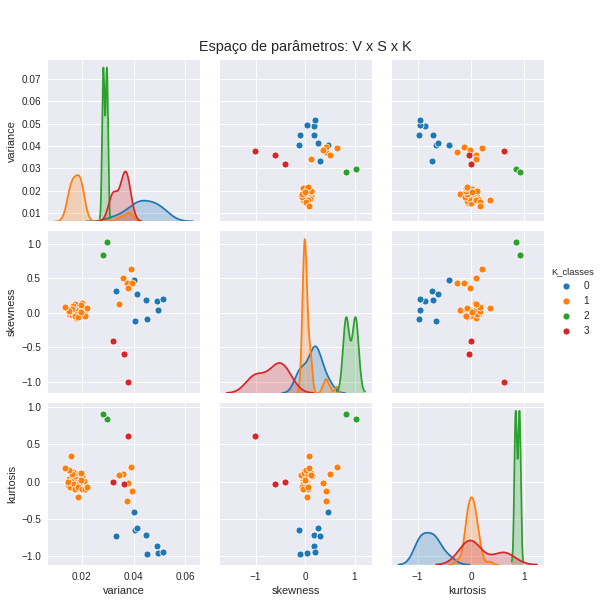

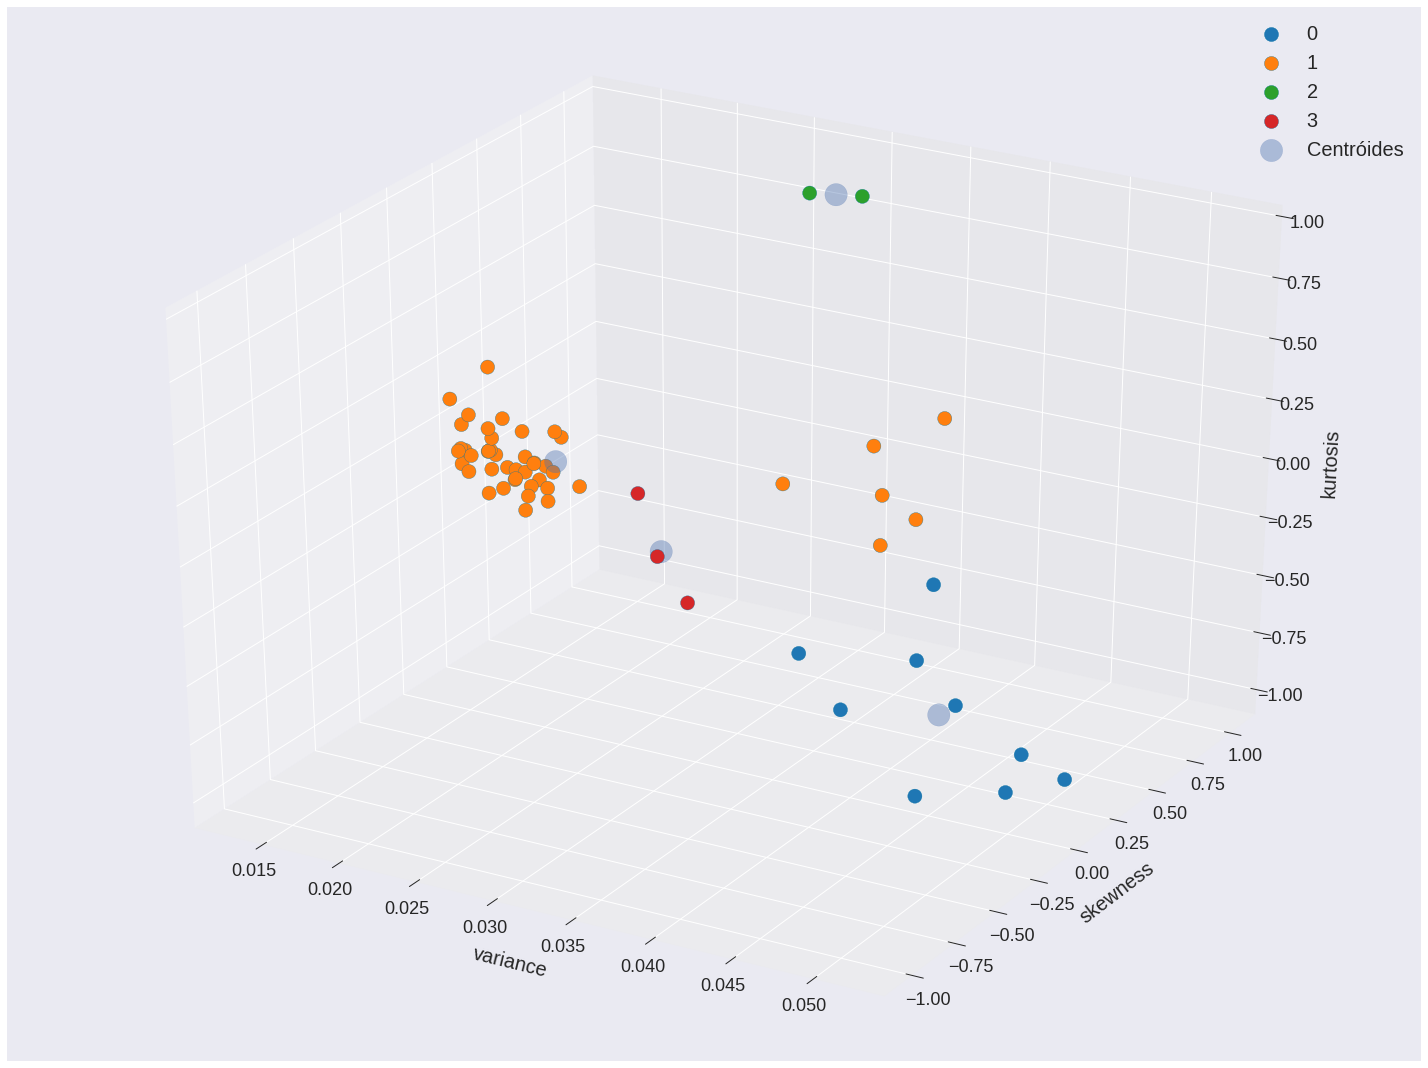



****************** Sinais na classe 1 ******************
                variance  skewness  kurtosis  K_classes
index                                                  
beta:0 iter:0   0.020217 -0.022340 -0.023871          1
beta:0 iter:1   0.016682 -0.004443  0.039377          1
beta:0 iter:2   0.017311 -0.015011  0.038648          1
beta:0 iter:3   0.015193 -0.023562  0.140599          1
beta:0 iter:4   0.015344 -0.019045  0.031875          1
beta:0 iter:5   0.017921  0.037123 -0.081919          1
beta:0 iter:6   0.019213 -0.013790  0.055261          1
beta:0 iter:7   0.019204  0.038251  0.005892          1
beta:0 iter:8   0.014684  0.016724 -0.050301          1
beta:0 iter:9   0.017759  0.009827 -0.019905          1
beta:0 iter:10  0.018551 -0.009564 -0.009948          1
beta:0 iter:11  0.018999  0.003435 -0.019590          1
beta:0 iter:12  0.019308  0.009073 -0.078007          1
beta:0 iter:13  0.015155 -0.027210  0.040803          1
beta:0 iter:14  0.020472 -0.007433  0.030659 

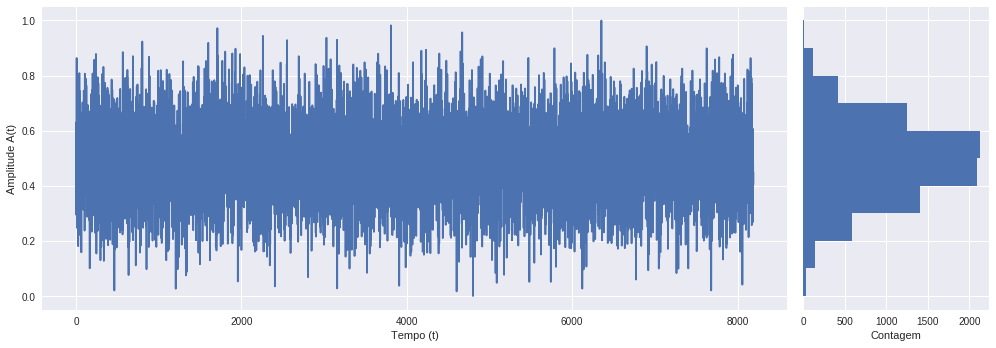



Deseja plotar algum dos sinais? (0- Não, 1- Sim): 1
Valor de beta: 1
Número da iteração: 4


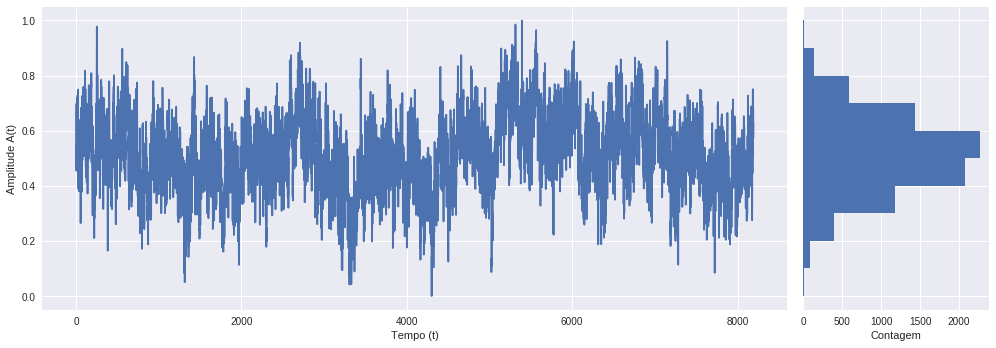



Deseja plotar algum dos sinais? (0- Não, 1- Sim): 1
Valor de beta: 2
Número da iteração: 10


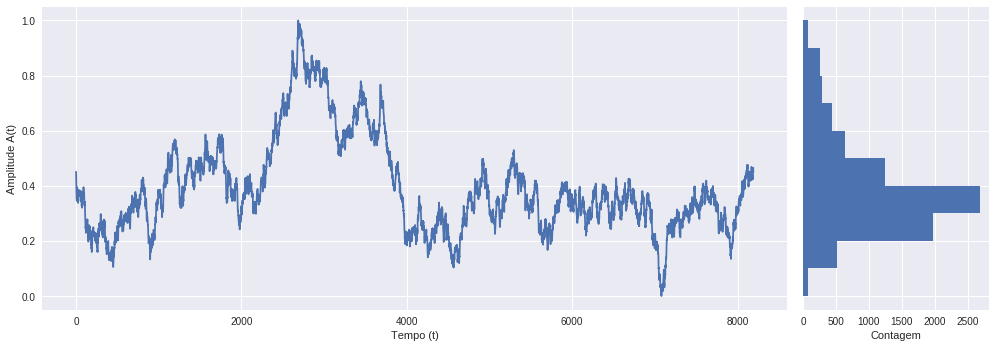



Deseja plotar algum dos sinais? (0- Não, 1- Sim): 0


Deseja salvar os valores dos sinas, momentos estatísticos e k-means em arquivos csv? (0- Não, 1- Sim): 0


In [9]:
# Lista com os valores de beta para geração dos sinais
beta = [x for x in range(0,2+1)]

GeradorRuido(n=8192,beta=beta,sinais=20,histograma=False)

A maior parte das discussões feitas para o exercício 1 valem também para este exercício. Note que mais uma vez, o número de clusters gerados não corresponde a número de família de sinais. No entanto, e ao contrário do exercício 1, a quantidade de clusters necessários para separar os dados foi maior do que a quantidade de família de sinais. Uma inspeção na tabela com os sinais pertencentes a cada classe mostra que isto ocorreu devido ao comportamento do ruído vermelho. Devido à natureza estocástica deste ruído, gerado devido ao movimento browniano, seus sinais não seguem uma distribuição específica entre todas as iterações, como é o caso dos ruídos branco e rosa que podem ser aproximados por uma gaussiana.   

Outro fato interessante foi a alocação de todos os ruídos brancos e rosas em um mesmo cluster, apesar desses sinais terem comportamentos visivelmente distintos, como mostrado nos dois primeiros gráficos acima. Contudo, os histogramas destes sinais mostram que ambos seguem uma distribuição próxima à normal, podendo ser este o motivo para a alocação destes sinais em um mesmo grupo.  